# Olympex validation

This notebook evaluates the CCIC retrieval against radar retrievals and in-situ measurements from the Olympex flight campaign.


In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from ccic.plotting import set_style

set_style()
DATA_PATH = Path("/home/simonpf/copper/ccic")

In [2]:
from datetime import datetime, timedelta
from pansat.time import to_datetime64

elev = xr.load_dataset(DATA_PATH / "validation/olympex/elevation_olympex.nc")

def read_citation_file(filename):
    with open(filename, "r") as lines:
        lines = lines.readlines()
    indices = lines[68].split()
    data = pd.read_csv(
        filename,
        skiprows=70,
        names=indices,
        delim_whitespace=True,
        na_values="999999.9999"
    )
    
    # Convert time
    year, month, day, *_ = Path(filename).name.split("_")
    start_time = to_datetime64(datetime(int(year) + 2000, int(month), int(day)))
    time = start_time + np.array(data.Time).astype("timedelta64[s]")
    data.index = time
    
    data = xr.Dataset(data).rename({"dim_0": "time"}).resample(time="30s").mean()
    data = data.rename({
        "POS_Lat": "latitude",
        "POS_Lon": "longitude",
    })
    sfc_elev = elev.interp(latitude=data.latitude, longitude=data.longitude)
    alt = data.POS_Alt.data - sfc_elev.elevation.data
    data["altitude"] = (("time",), alt)
    return data

## Overview plot

In [3]:
citation_files = sorted(list(Path(DATA_PATH / "validation/olympex/citation/").glob("*.olympex")))
olympex_files = sorted(list(Path(DATA_PATH / "validation/olympex/results").glob("*.nc")))

/home/simonpf/copper/ccic/validation/olympex/citation/15_11_23_14_49_18.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_11_23_20_23_09.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_11_24_15_55_25.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_11_24_18_33_52.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_01_22_29_17.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_03_13_35_43.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_04_12_46_53.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_04_16_50_19.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_05_14_17_47.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_10_14_14_54.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_12_16_39_54.olympex
/home/simonpf/copper/ccic/validation/olympex/citation/15_12_13_15_39_28.olympex
/home/simonpf/copper/ccic/validation/oly

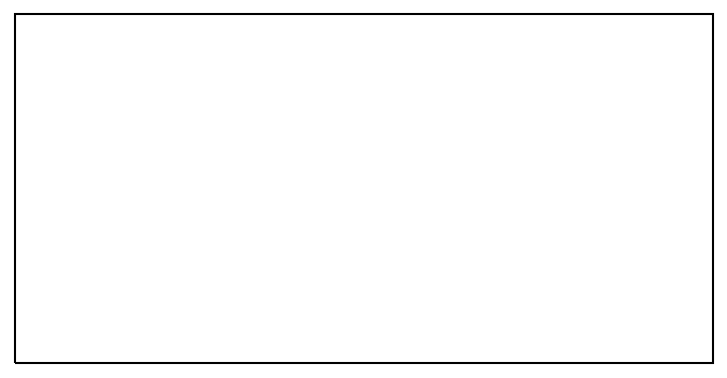

In [4]:
import cartopy.crs as ccrs

lons_citation = []
lats_citation = []
lons_er2 = []
lats_er2 = []

for citation_file in citation_files:
    print(citation_file)
    citation_data = read_citation_file(citation_file)
    lons = citation_data.longitude.data
    lats = citation_data.latitude.data
    lons_citation.append(lons)
    lats_citation.append(lats)
    
for olympex_file in olympex_files:
    print(olympex_file)
    data = xr.load_dataset(olympex_file, group="LargePlateAggregate")
    lons = data.longitude.data
    lats = data.latitude.data
    lons_er2.append(lons)
    lats_er2.append(lats)
    


In [3]:
import cartopy.crs as ccrs
from matplotlib.ticker import FixedLocator

def add_ticks(ax, lons, lats, left=True, bottom=True):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = left
    gl.bottom_labels = bottom
    gl.xlocator = FixedLocator(lons)
    gl.ylocator = FixedLocator(lats)


In [4]:
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
os.environ["CARTOPY_USER_BACKGROUNDS"] = str(DATA_PATH / "misc")

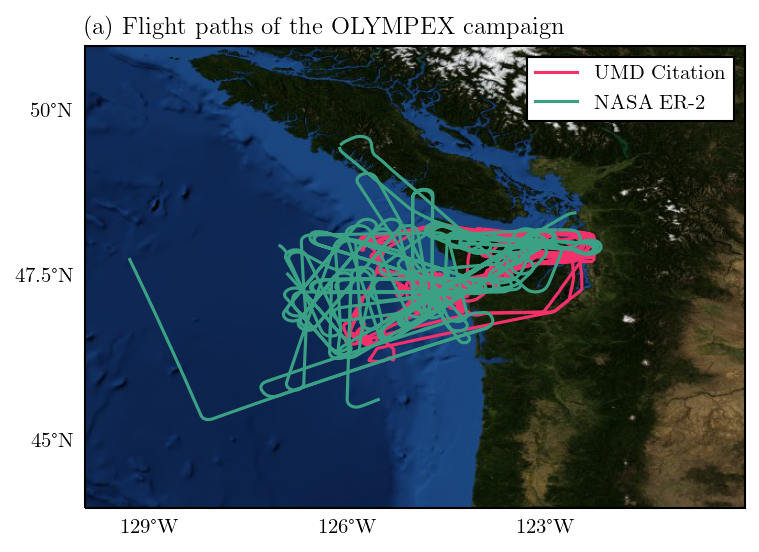

In [28]:
fig = plt.figure(figsize=(6, 4))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=crs)

for ind, (lons, lats) in enumerate(zip(lons_citation, lats_citation)):
    ax.plot(lons, lats, c="C0", label= "UMD Citation" if ind == 0 else None)
    
for ind, (lons, lats) in enumerate(zip(lons_er2, lats_er2)):
    ax.plot(lons, lats, c="C1", label= "NASA ER-2" if ind == 0 else None)
    
lon_ticks = np.linspace(-135, -120, 6)
lat_ticks = [45, 47.5, 50]
add_ticks(ax, lon_ticks, lat_ticks)

ax.set_xlim(-130, -120)
ax.set_ylim(44, 51)
ax.legend()

ax.set_title("(a) Flight paths of the OLYMPEX campaign")

ax.background_img(name='blue_marble_dec', resolution='low')
fig.savefig("olympex_flight_paths.pdf", )

## Resample Citation data

The code below resamples the in-situe measurements from the Citation aircraft to the CCIC retrieval grids.

In [5]:
citation_files = sorted(list(Path(DATA_PATH / "validation/olympex/citation/").glob("*.olympex")))

In [6]:
from datetime import datetime, timedelta
from pansat.time import to_datetime64

elev = xr.load_dataset("/home/simonpf/data_3/ccic/validation/data/elevation_olympex.nc")

def read_citation_file(filename):
    with open(filename, "r") as lines:
        lines = lines.readlines()
    indices = lines[68].split()
    data = pd.read_csv(
        filename,
        skiprows=70,
        names=indices,
        delim_whitespace=True,
        na_values="999999.9999"
    )
    
    # Convert time
    year, month, day, *_ = Path(filename).name.split("_")
    start_time = to_datetime64(datetime(int(year) + 2000, int(month), int(day)))
    time = start_time + np.array(data.Time).astype("timedelta64[s]")
    data.index = time
    
    data = xr.Dataset(data).rename({"dim_0": "time"}).resample(time="30s").mean()
    data = data.rename({
        "POS_Lat": "latitude",
        "POS_Lon": "longitude",
    })
    sfc_elev = elev.interp(latitude=data.latitude, longitude=data.longitude)
    alt = data.POS_Alt.data - sfc_elev.elevation.data
    data["altitude"] = (("time",), alt)
    return data

In [7]:
from ccic.validation import get_latlon_bins
cpcir_file = DATA_PATH / "results/olympex/ccic_cpcir_201511010000.nc"
bins_cpcir = get_latlon_bins(cpcir_file)
gridsat_file = DATA_PATH / "results/olympex/ccic_gridsat_201511010000.nc"
bins_gridsat = get_latlon_bins(gridsat_file)

In [8]:
from ccic.validation import resample_data
for citation_file in citation_files:
    for name, dt, bins in zip(["cpcir", "gridsat"], [0.5, 0.5], [bins_cpcir, bins_gridsat]):
        resample_data(
            read_citation_file(citation_file),
            ["Nev_IWC", "Nev_TWC"],
            bins[1],
            bins[0],
            dt,
            DATA_PATH / "validation/olympex/citation_resampled/",
            f"citation_{name}_{{year:04}}{{month:02}}{{day:02}}{{hour:02}}.nc"
        )

In [9]:
DATA_PATH

PosixPath('/home/simonpf/copper/ccic')

In [10]:
from ccic.validation import load_radar_results
from ccic.validation import resample_data
olympex_files = sorted(list(Path(DATA_PATH / "validation/olympex/results").glob("*.nc")))
olympex_files = sorted(list(Path("/home/simonpf/data_3/ccic/validation/olympex/results_new").glob("*.nc")))

results = {}
groups = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]
for group in groups:
    scene = 0
    for olympex_file in olympex_files:
        
        try:
            rs = xr.load_dataset(olympex_file, group=group)
            timed = (rs.time.data - rs.time.data.astype("datetime64[D]").astype("datetime64[s]"))
            timed = timed.astype("timedelta64[s]").astype("float64") / 3600

            for name, dt, bins in zip(["cpcir", "gridsat"], [0.5, 0.5], [bins_cpcir, bins_gridsat]):
                resample_data(
                    rs,
                    ["iwc", "rwc", "temperature"],
                    bins[1],
                    bins[0],
                    dt,
                    DATA_PATH / "validation/olympex/radar_resampled/",
                    f"radar_{name}_{group}_{{year:04}}{{month:02}}{{day:02}}{{hour:02}}.nc"
                )
        except Exception as exc:
            raise exc


## Load and combine resampled data

Ths code below loads the data resampled to the CPCIR grids and combines them into a dictionary containing the radar retrieval results for the three evaluated particles.

In [11]:
citation_path = Path(DATA_PATH / "validation/olympex/citation_resampled")
radar_path = Path(DATA_PATH / "validation/olympex/radar_resampled")
ccic_path = Path(DATA_PATH / "results/olympex/")

particles = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]
citation_files = sorted(list(citation_path.glob("*cpcir*.nc")))
ccic_files = sorted(list(ccic_path.glob("*cpcir*.nc")))

citation_data = []

results_cpcir = {}

for particle in particles:
    for ccic_file in ccic_files:
        
        date = ccic_file.name.split("_")[-1][:10]
        citation_files = sorted(list(citation_path.glob(f"*cpcir*{date}.nc")))
        radar_files = sorted(list(radar_path.glob(f"radar_cpcir_{particle}_{date}.nc")))
        
        if len(radar_files) == 0 and len(citation_files) == 0:
            continue
        
        ccic_data = xr.load_dataset(ccic_file)
        
        dims = ("time", "latitude", "longitude", "altitude")
        
        try:
            radar_data = xr.load_dataset(radar_files[0])
            ccic_data["tiwc_radar"] = (dims, radar_data.iwc.data.astype("float32"))
            ccic_data["temperature"] = (dims, radar_data.temperature.data.astype("float32"))
        except Exception as e:
            print("No radar data:", ccic_file)
            ccic_data["tiwc_radar"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data, dtype="float32")
            )
            ccic_data["temperature"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data, dtype="float32")
            )
            
        try:
            citation_data = xr.load_dataset(citation_files[0])
            ccic_data["tiwc_citation"] = (dims, citation_data.Nev_IWC.data)
        except Exception:
            print("No in-situ data:", ccic_file)
            ccic_data["tiwc_citation"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data)
            )
        results_cpcir.setdefault(particle, []).append(ccic_data)

for particle in particles:
    results_cpcir[particle] = xr.concat(results_cpcir[particle], "time")

No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511101700.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511101800.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511181800.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511181900.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511182000.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511182100.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511182200.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511231900.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511232200.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511232300.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201511241500.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex

No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512012100.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512012300.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512020000.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512020100.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512031700.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512041600.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512042000.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512051600.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512051700.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512051800.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512051800.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cp

No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512082100.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512082200.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512082300.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101400.nc
No radar data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101500.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101500.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101600.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101700.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101800.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512101900.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex/ccic_cpcir_201512102000.nc
No in-situ data: /home/simonpf/copper/ccic/results/olympex

In [39]:
particles = ["LargePlateAggregate", "LargeColumnAggregate", "8-ColumnAggregate"]
citation_files = sorted(list(citation_path.glob("*gridsat*.nc")))
ccic_files = sorted(list(ccic_path.glob("*gridsat*.nc")))

citation_data = []

results_gridsat = {}

for particle in particles:
    for ccic_file in ccic_files:
        
        date = ccic_file.name.split("_")[-1][:10]
        citation_files = sorted(list(citation_path.glob(f"*gridsat*{date}.nc")))
        radar_files = sorted(list(radar_path.glob(f"radar_gridsat_{particle}_{date}.nc")))
        
        if len(radar_files) == 0 and len(citation_files) == 0:
            continue
        
        ccic_data = xr.load_dataset(ccic_file)
        
        dims = ("time", "latitude", "longitude", "altitude")
        
        try:
            radar_data = xr.load_dataset(radar_files[0])[{"time": [0]}]
            ccic_data["tiwc_radar"] = (dims, radar_data.iwc.data)
            ccic_data["temperature"] = (dims, radar_data.temperature.data.astype("float32"))
        except Exception as exc:
            ccic_data["tiwc_radar"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data)
            )
            ccic_data["temperature"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data)
            )
            
        try:
            citation_data = xr.load_dataset(citation_files[0])[{"time": [0]}]
            ccic_data["tiwc_citation"] = (dims, citation_data.Nev_IWC.data)
        except Exception:
            ccic_data["tiwc_citation"] = (
                dims, np.nan * np.ones_like(ccic_data.tiwc.data)
            )
        results_gridsat.setdefault(particle, []).append(ccic_data)

for particle in particles:
    results_gridsat[particle] = xr.concat(results_gridsat[particle], "time")

In [40]:
results_gridsat["LargePlateAggregate"].tiwc_radar.max()

<xarray.DataArray 'tiwc_radar' ()>
array(0.00075599)

## Results

In [41]:
def get_iwc_citation_radar(data):
    """
    Extract collocations between citation in-situ measurements and radar retrievals.
    """
    iwc_ref = np.maximum(data.tiwc_citation.data, 0.0)
    iwc = data.tiwc_radar.data * 1e3
    valid = (iwc_ref >= 0.0) * (iwc >= 0.0)
    return iwc_ref[valid], iwc[valid]

def get_iwc_citation_ccic(data):
    """
    Extract collocations between citation in-situe measurements and CCIC retrievals.
    """
    iwc_ref = np.maximum(data.tiwc_citation.data, 0.0)
    iwc = data.tiwc.data
    valid = (iwc_ref >= 0.0) * (iwc >= 0.0)
    return iwc_ref[valid], iwc[valid]

def get_iwc_radar_ccic(data):
    """
    Extract collocations between citation in-situe measurements and CCIC retrievals.
    """
    iwc_ref = data.tiwc_radar.data * 1e3
    iwc = data.tiwc.data
    valid = np.all(iwc_ref >= 0.0, -1)[..., None] * (iwc >= 0.0)
    print(np.all(iwc_ref >= 0.0, -1)[..., None].sum())
    return iwc_ref[valid], iwc[valid]

97.99539774994639
293.0963370438172
-28.408702195614524


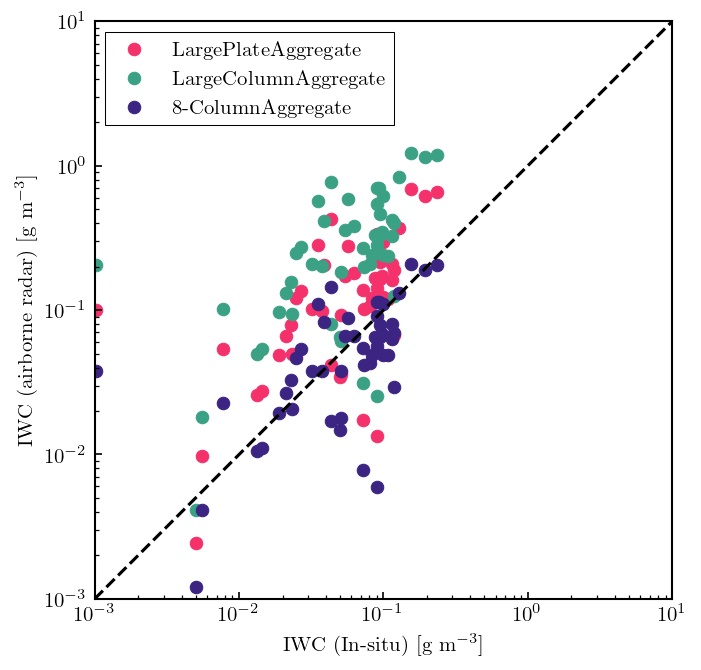

In [42]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

x = np.logspace(-3, 1, 101)
ax.plot(x, x, c="k", ls="--")

iwc_ref, iwc = get_iwc_citation_radar(results_cpcir["LargePlateAggregate"])
ax.scatter(iwc_ref, iwc, label="LargePlateAggregate")
bias = 100 * (iwc - iwc_ref).mean() / iwc_ref.mean()
print(bias)

iwc_ref, iwc = get_iwc_citation_radar(results_cpcir["LargeColumnAggregate"])
ax.scatter(iwc_ref, iwc, label="LargeColumnAggregate")
bias = 100 * (iwc - iwc_ref).mean() / iwc_ref.mean()
print(bias)

iwc_ref, iwc = get_iwc_citation_radar(results_cpcir["8-ColumnAggregate"])
ax.scatter(iwc_ref, iwc, label="8-ColumnAggregate")
bias = 100 * (iwc - iwc_ref).mean() / iwc_ref.mean()
print(bias)

ax.set_xlim(1e-3, 1e1)
ax.set_ylim(1e-3, 1e1)
ax.set_aspect(1)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("IWC (In-situ) [g m$^{-3}$]")
ax.set_ylabel("IWC (airborne radar) [g m$^{-3}$]")
ax.legend()

f.savefig("../figures/radar_only_olympex.pdf", bbox_inches="tight")

In [1]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import binned_statistic_2d

gs = GridSpec(2, 5, width_ratios=(0.4, 1.0, 1.0, 0.1, 0.075), wspace=0.075, hspace=0.05)
fig = plt.figure(figsize=(12, 10))

norm = LogNorm(1e-2, 1e2)
txtcol = "orangered"
diagcol = "orangered"
names = ["CPCIR", "GridSat"]

temp_norm = Normalize(220, 270)
temp_levels = np.linspace(220, 270, 6)

for i, (name, results) in enumerate(zip(names, [results_cpcir, results_gridsat])):
    
    ax = fig.add_subplot(gs[i, 0])
    ax.text(0, 0, name, rotation=90, va="center", ha="center", fontsize=14)
    ax.set_axis_off()
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 1)
    
    
    bins = np.logspace(-4, 1, 21)
    iwc_ref, iwc = get_iwc_citation_ccic(results["8-ColumnAggregate"])
    y = np.histogram2d(iwc_ref, iwc, bins=bins, density=True)[0]
    y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
    ax = fig.add_subplot(gs[i, 1])
    x = 0.5 * (bins[1:] + bins[:-1])
    ax.pcolormesh(x, x, np.maximum(y.T, 1e-3), norm=norm, rasterized=True)
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)

    corr = np.corrcoef(iwc_ref, iwc)[0, 1]
    bias = (iwc - iwc_ref).mean() / iwc_ref.mean()
    props = dict(facecolor='white', alpha=0.5, edgecolor="grey")
    ax.text(0.5, 1.5e-4, f"Corr.: {corr:0.2f} \n Bias: {100 * bias:0.2f}\%",
            fontsize=12, color=txtcol, ha="left", va="bottom", bbox=props)
    
    iwc_ref = results["8-ColumnAggregate"].tiwc_citation.data
    iwc = results["8-ColumnAggregate"].tiwc.data
    temp = results["8-ColumnAggregate"].temperature.data
    valid = np.isfinite(iwc_ref) * np.isfinite(iwc)
    bins = np.logspace(-4, 1, 11)
    y = binned_statistic_2d(iwc_ref[valid], iwc[valid], temp[valid], bins=bins)[0]
    x = 0.5 * (bins[1:] + bins[:-1])
    #ax.contour(x, x, y.T, cmap="Oranges_r", levels=temp_levels, norm=temp_norm)

    ax.set_ylabel("TIWC (retrieved) [kg m$^{-3}$]")
    if i == 0:
        ax.set_title("In-situ measurements", loc="center", fontsize=14)
        for l in ax.xaxis.get_ticklabels():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)
    else:
        ax.set_xlabel("TIWC (reference) [kg m$^{-3}$]")

    bins = np.logspace(-4, 1, 21)

    iwc_ref, iwc = get_iwc_radar_ccic(results["8-ColumnAggregate"])
    y = np.histogram2d(iwc_ref, iwc, bins=bins, density=True)[0]
    y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
    ax = fig.add_subplot(gs[i, 2])
    m = ax.pcolormesh(bins, bins, np.maximum(y.T, 1e-3), norm=norm, rasterized=True)
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)

    if i == 0:
        ax.set_title("Airborne radar", loc="center", fontsize=14)
        for l in ax.xaxis.get_ticklabels():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)
    else:
        ax.set_xlabel("TIWC (reference) [kg m$^{-3}$]")
    for l in ax.yaxis.get_ticklines():
        l.set_visible(False)
    for l in ax.yaxis.get_ticklabels():
        l.set_visible(False)
        
    corr = np.corrcoef(iwc_ref, iwc)[0, 1]
    bias = (iwc - iwc_ref).mean() / iwc_ref.mean()
    props = dict(facecolor='white', alpha=0.5, edgecolor="grey")
    ax.text(0.5, 1.5e-4, f"Corr.: {corr:0.2f} \n Bias: {100 * bias:0.2f}\%",
            fontsize=12, color=txtcol, ha="left", va="bottom", bbox=props)
    
    iwc_ref = results["8-ColumnAggregate"].tiwc_radar.data * 1e3
    iwc = results["8-ColumnAggregate"].tiwc.data
    temp = results["8-ColumnAggregate"].temperature.data
    valid = np.isfinite(iwc_ref) * np.isfinite(iwc)
    bins = np.logspace(-4, 1, 11)
    y = binned_statistic_2d(iwc_ref[valid], iwc[valid], temp[valid], bins=bins)[0]
    x = 0.5 * (bins[1:] + bins[:-1])
    #m_temp = ax.contour(x, x, y.T, cmap="Oranges_r", levels=temp_levels, norm=temp_norm)


ax = fig.add_subplot(gs[:, -1])
cb = plt.colorbar(m, cax=ax)
cb.set_label(label="p(retrieved $|$ reference)")
ax.yaxis.set_label_position('left')

ax = ax.twinx()
cb = plt.colorbar(m_alt, cax=ax)
cb.set_label("Mean temperature [K]", color="orangered")

fig.savefig("../figures/olympex_scatter.pdf", bbox_inches="tight")

NameError: name 'plt' is not defined

/tmp/ipykernel_1948410/1949096465.py:17: RuntimeWarning: invalid value encountered in divide
  y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)


1376


/tmp/ipykernel_1948410/1949096465.py:46: RuntimeWarning: invalid value encountered in divide
  y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)


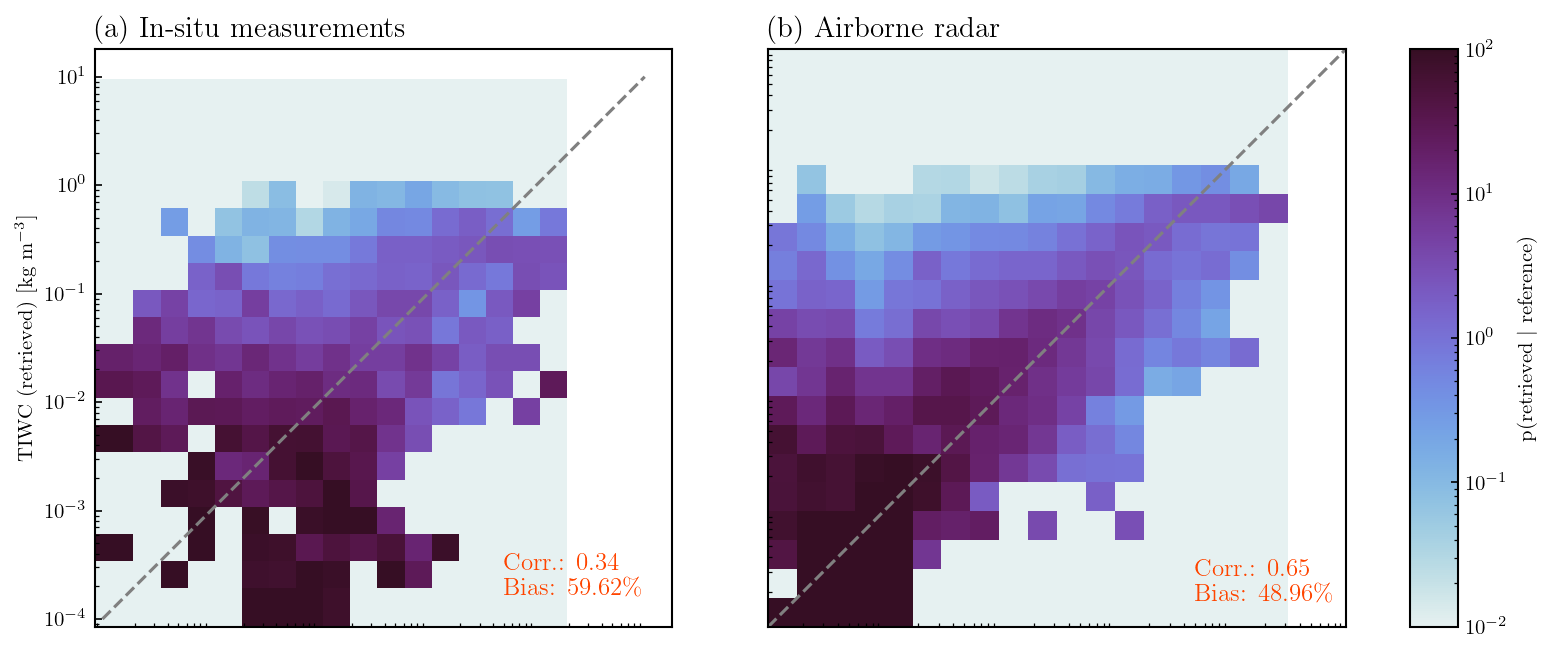

In [47]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

gs = GridSpec(1, 3, width_ratios=(1.0, 1.0, 0.075), wspace=0.075, hspace=0.05)
fig = plt.figure(figsize=(12, 5))

norm = LogNorm(1e-2, 1e2)
txtcol = "orangered"
diagcol = "orangered"
names = ["CPCIR"]

for i, (name, results) in enumerate(zip(names, [results_cpcir])):
    
    bins = np.logspace(-4, 1, 21)
    iwc_ref, iwc = get_iwc_citation_ccic(results["8-ColumnAggregate"])
    y = np.histogram2d(iwc_ref, iwc, bins=bins, density=True)[0]
    y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
    ax = fig.add_subplot(gs[i, 0])
    x = 0.5 * (bins[1:] + bins[:-1])
    levels = np.logspace
    ax.pcolormesh(x, x, np.maximum(y.T, 1e-3), norm=norm, rasterized=True)
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)

    corr = np.corrcoef(iwc_ref, iwc)[0, 1]
    bias = (iwc - iwc_ref).mean() / iwc_ref.mean()
    ax.text(0.5, 1.5e-4, f"Corr.: {corr:0.2f} \n Bias: {100 * bias:0.2f}\%",
            fontsize=12, color=txtcol, ha="left", va="bottom")

    ax.set_ylabel("TIWC (retrieved) [kg m$^{-3}$]")
    if i == 0:
        ax.set_title("(a) In-situ measurements", loc="left", fontsize=14)
        for l in ax.xaxis.get_ticklabels():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)
    else:
        ax.set_xlabel("TIWC (reference) [kg m$^{-3}$]")

    bins = np.logspace(-4, 1, 21)

    iwc_ref, iwc = get_iwc_radar_ccic(results["LargePlateAggregate"])
    y = np.histogram2d(iwc_ref, iwc, bins=bins, density=True)[0]
    y /= np.sum(y * np.diff(bins)[None], axis=1, keepdims=True)
    ax = fig.add_subplot(gs[i, 1])
    m = ax.pcolormesh(bins, bins, np.maximum(y.T, 1e-3), norm=norm, rasterized=True)
    ax.plot(bins, bins, c="grey", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect(1.0)

    if i == 0:
        ax.set_title("(b) Airborne radar", loc="left", fontsize=14)
        for l in ax.xaxis.get_ticklabels():
            l.set_visible(False)
        for l in ax.xaxis.get_ticklines():
            l.set_visible(False)
    else:
        ax.set_xlabel("TIWC (reference) [kg m$^{-3}$]")
    for l in ax.yaxis.get_ticklines():
        l.set_visible(False)
    for l in ax.yaxis.get_ticklabels():
        l.set_visible(False)


    corr = np.corrcoef(iwc_ref, iwc)[0, 1]
    bias = (iwc - iwc_ref).mean() / iwc_ref.mean()
    ax.text(0.5, 1.5e-4, f"Corr.: {corr:0.2f} \n Bias: {100 * bias:0.2f}\%",
            fontsize=12, color=txtcol, ha="left", va="bottom")

ax = fig.add_subplot(gs[:, 2])
plt.colorbar(m, cax=ax, label="p(retrieved $|$ reference)")
fig.savefig("../figures/validation_olympex_cpcir.pdf", bbox_inches="tight")

In [49]:
def get_tiwp_radar_ccic(data):
    """
    Extract collocations between in_situ in-situe measurements and CCIC retrievals.
    """
    tiwc_ref = data[f"tiwc_radar"].data
    tiwc = data.tiwc.data
    alt = data.altitude.data
    tiwp_ref = np.sum(tiwc_ref, -1) * 1e3
    tiwp = data.tiwp.data
    
    print(np.nanmin(tiwp_ref), np.nanmax(tiwp_ref))
    valid = np.all(tiwc_ref >= 0.0, -1)
    print(valid.sum())
    return tiwp_ref[valid], tiwp[valid]

### Average profiles

In [28]:
def get_profiles_radar_ccic(data):
    """
    Extract collocations between citation in-situe measurements and CCIC retrievals.
    """
    data = data[{"altitude": slice(0, 20)}]
    tiwc_ref = data.tiwc_radar.data * 1e3
    tiwc = data.tiwc.data
    valid = np.all(tiwc_ref >= 0.0, axis=-1) * np.all((tiwc >= 0.0), -1)
    return tiwc_ref[valid], tiwc[valid]

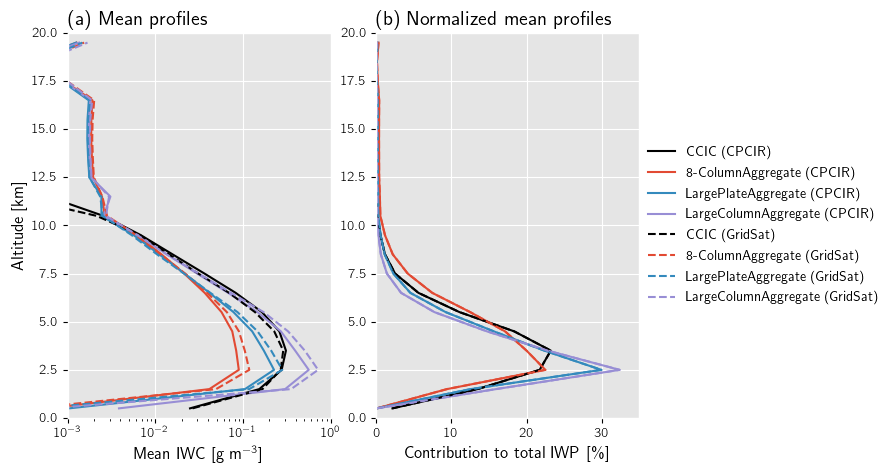

In [29]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.6])
levels = results_gridsat["LargeColumnAggregate"].altitude.data / 1e3


ax = fig.add_subplot(gs[0, 0])
handles = []
particles = ["8-ColumnAggregate", "LargePlateAggregate", "LargeColumnAggregate"]
for name, style, results in zip(["CPCIR", "GridSat"], ["-", "--"], [results_cpcir, results_gridsat]):
    for i, part in enumerate(particles):
        iwc_ref, iwc = get_profiles_radar_ccic(results[part])
        profs_ref = np.nanmean(iwc_ref, 0)
        profs = np.nanmean(iwc, 0)
        if i == 0:
            handles += ax.plot( profs, levels, label=f"CCIC ({name})", c="k", ls=style)
        handles += ax.plot(profs_ref, levels, label=f"{part} ({name})", ls=style, c=f"C{i}")
    
ax.set_ylim(0, 20)
ax.set_xscale("log")
ax.set_xlim(1e-3, 1e0)
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Mean IWC [g m$^{-3}$]")
ax.set_title("(a) Mean profiles", loc="left")

ax = fig.add_subplot(gs[0, 1])
handles = []
for name, style, results in zip(["CPCIR", "GridSat"], ["-", "--"], [results_cpcir, results_gridsat]):
    for i, part in enumerate(particles):
        iwc_ref, iwc = get_profiles_radar_ccic(results_gridsat[part])
        profs_ref = np.nanmean(iwc_ref, 0)
        profs = np.nanmean(iwc, 0)
        if i == 0:
            handles += ax.plot(100 * profs / profs.sum(), levels, label=f"CCIC ({name})", c="k", ls=style)
        handles += ax.plot(100 * profs_ref / profs_ref.sum(), levels, label=f"{part} ({name})", ls=style, c=f"C{i}")

ax.set_ylim(0, 20)
ax.set_xlim(0, 35)
ax.set_title("(b) Normalized mean profiles", loc="left")
ax.set_xlabel("Contribution to total IWP [\%]")

ax = fig.add_subplot(gs[0, 2])
ax.set_axis_off()
ax.legend(handles=handles, loc="center", facecolor="none", edgecolor="none")
fig.savefig("../figures/olympex_profiles.png")

## Case study

In [3]:
from datetime import datetime
from pathlib import Path
from ccic.data.cpcir import gpm_mergeir, PROVIDER

start_time = datetime(2015, 12, 3, 16)
end_time = datetime(2015, 12, 3, 16)
cpcir_file = Path("GPM/gpm_mergeir/merg_2015120316_4km-pixel.nc4")
if not cpcir_file.exists():
    file = gpm_mergeir.download(start_time, end_time)
cpcir_data = xr.load_dataset(cpcir_file)

In [4]:
from ccic.validation import great_circle_distance
radar_data = xr.load_dataset(
    DATA_PATH / "validation/olympex/results_new/crs_olympex_201512031559_201512031649.nc",
    group="8-ColumnAggregate"
)
lons = radar_data.longitude
lats = radar_data.latitude
time = radar_data.time
dist = np.array([great_circle_distance(lats[i], lons[i], lats[i + 1], lons[i + 1]) for i in range(lats.size - 1)])
dist = np.concatenate([[0], np.cumsum(dist)])
ccic_cpcir_data = xr.load_dataset("/home/simonpf/data_3/ccic/results/olympex/ccic_cpcir_201512031600.nc")
tiwp_cpcir = ccic_cpcir_data.tiwp.copy()
ccic_gridsat_data = xr.load_dataset("/home/simonpf/data_3/ccic/results/olympex/ccic_gridsat_201512031500.nc")[{"time": 0}].drop_vars("time")
tiwp_gridsat = ccic_gridsat_data.tiwp.copy()

In [5]:
citation_data = read_citation_file(DATA_PATH / "validation/olympex/citation/15_12_03_13_35_43.olympex")
lons_citation = citation_data.longitude.data
lats_citation = citation_data.latitude.data
time_citation = citation_data.time.data

In [6]:
from ccic.data.cpcir import CPCIR_GRID
cpcir_files = [
    DATA_PATH / "results/olympex/ccic_cpcir_201512031500.nc",
    DATA_PATH / "results/olympex/ccic_cpcir_201512031600.nc",
    DATA_PATH / "results/olympex/ccic_cpcir_201512031700.nc",
    DATA_PATH / "results/olympex/ccic_cpcir_201512031800.nc",
]
ccic_cpcir_data = xr.concat(
    [xr.load_dataset(filename) for filename in cpcir_files],
    dim="time"
)
tiwp = ccic_cpcir_data.tiwp[{"time": 2}]

lon_min = ccic_cpcir_data.longitude.data.min()
lon_start = np.where(cpcir_data.lon.data >= lon_min)[0][0]
lat_min = ccic_cpcir_data.latitude.data.min()
lat_start = np.where(cpcir_data.lat.data >= lat_min)[0][0]
area = CPCIR_GRID[-(lat_start + 256): -lat_start, lon_start: lon_start + 256]

cpcir_tbs = cpcir_data.interp(lat=ccic_cpcir_data.latitude, lon=ccic_cpcir_data.longitude)
ccic_cpcir_data = ccic_cpcir_data.interp(time=time, latitude=lats, longitude=lons)

In [7]:
gridsat_files = [
    DATA_PATH / "ccic/results/olympex/ccic_gridsat_201512031500.nc",
    DATA_PATH / "ccic/results/olympex/ccic_gridsat_201512031800.nc",
]
ccic_gridsat_data = xr.concat(
    [xr.load_dataset(filename) for filename in gridsat_files],
    dim="time"
)
ccic_gridsat_data = ccic_gridsat_data.interp(time=time, latitude=lats, longitude=lons)

In [8]:
import cartopy.crs as ccrs
from matplotlib.ticker import FixedLocator

def add_ticks(ax, lons, lats, left=True, bottom=True):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = left
    gl.bottom_labels = bottom
    gl.xlocator = FixedLocator(lons)
    gl.ylocator = FixedLocator(lats)


## Map Citation measurements to ER-2 ground track

The in-situ measurements from the Citation aircraft are mapped to the flight path of the ER-2 aircraft by determining the ER-2 times of the positions closes to the Citation measurements. 

In [9]:
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
lon_cit = citation_data.longitude.data
lat_cit = citation_data.latitude.data
lon_rad = radar_data.longitude.data
lat_rad = radar_data.latitude.data
time_rad = radar_data.time.data
t_t = time_rad.dtype

swath_cit = SwathDefinition(lon_cit, lat_cit)
swath_radar = SwathDefinition(lon_rad, lat_rad)

time_r = resample_nearest(
    swath_radar,
    time_rad.astype(np.int64),
    swath_cit,
    radius_of_influence=5e3,
    fill_value=-1
)
invalid = time_r < 0
time_r = time_r.astype(t_t)
delta_t = (time_r - citation_data.time.data).astype("timedelta64[s]")

invalid = np.abs(delta_t) > np.timedelta64(30 * 60, "s")
time_r[invalid] = np.datetime64("nat")

In [10]:
from ccic.plotting import set_style
set_style()

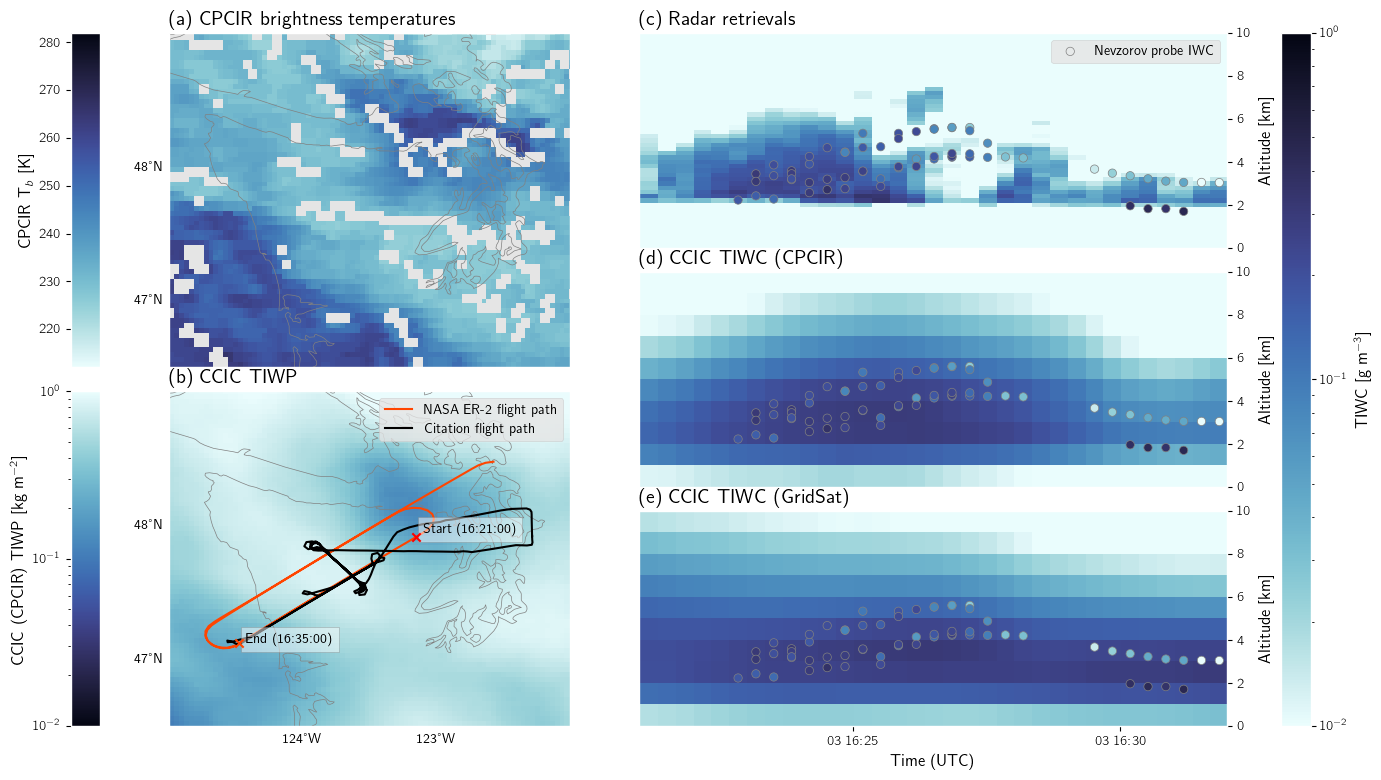

In [24]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 9))
gs = GridSpec(6, 4, width_ratios=[0.075, 1.1, 1.5, 0.075], wspace=0.2, hspace=0.25)

start = np.datetime64("2015-12-03T16:21:00", "s")
end = np.datetime64("2015-12-03T16:32:00", "s")

ind_start = np.where(radar_data.time > start)[0][0]
ind_end = np.where(radar_data.time > end)[0][0]
crs = area.to_cartopy_crs()

# CPCIR input
                 
ax = fig.add_subplot(gs[:3, 1], projection=crs)
ext = area.area_extent
ext = (ext[0], ext[2], ext[1], ext[3])
m = ax.imshow(cpcir_tbs.Tb.data[1], extent=ext, rasterized=True)

ax.set_xlim(-125, -122)
ax.set_ylim(46.5, 49)

#ax.plot(radar_data.longitude.data, radar_data.latitude.data, c="grey")
#ax.plot(citation_data.longitude.data, citation_data.latitude.data, c="black")
#ax.text(radar_data.longitude.data[ind_start], radar_data.latitude.data[ind_start], "Start", color="red", ha="left", va="bottom")
#ax.scatter([radar_data.longitude.data[ind_start]], [radar_data.latitude.data[ind_start]], marker="x", color="red", zorder=10)
#ax.text(radar_data.longitude.data[ind_end], radar_data.latitude.data[ind_end], "End")
#ax.scatter([radar_data.longitude.data[ind_end]], [radar_data.latitude.data[ind_end]], marker="x", color="red", zorder=10)
ax.set_title("(a) CPCIR brightness temperatures", loc="left")


add_ticks(ax, np.arange(-125, -121), np.arange(46.0, 50), bottom=False)
ax.coastlines(color="grey")

ax = fig.add_subplot(gs[:3, 0])
plt.colorbar(m, label="CPCIR T$_b$ [K]", cax=ax, location="left")

# CPCIR TIWP

ax = fig.add_subplot(gs[3:6, 1], projection=crs)
m = ax.imshow(tiwp, extent=ext, norm=LogNorm(1e-2, 1e0), rasterized=True, cmap="cmo.ice")

ax.plot(radar_data.longitude.data, radar_data.latitude.data, c="orangered", label="NASA ER-2 flight path")
ax.plot(citation_data.longitude.data, citation_data.latitude.data, c="black", label="Citation flight path")
ax.legend()
ax.set_xlim(-125, -122)
ax.set_ylim(46.5, 49)

props = dict(facecolor='white', alpha=0.5, edgecolor="grey")
ax.text(radar_data.longitude.data[ind_start] + 0.05, radar_data.latitude.data[ind_start], "Start (16:21:00)", color="black", ha="left", va="bottom", bbox=props)
ax.scatter([radar_data.longitude.data[ind_start]], [radar_data.latitude.data[ind_start]], marker="x", color="red", zorder=10)
ax.text(radar_data.longitude.data[ind_end] + 0.05, radar_data.latitude.data[ind_end], "End (16:35:00)", color="black", bbox=props)
ax.scatter([radar_data.longitude.data[ind_end]], [radar_data.latitude.data[ind_end]], marker="x", color="orangered", zorder=10)
ax.set_title("(b) CCIC TIWP", loc="left")

add_ticks(ax, np.arange(-125, -121), np.arange(46.0, 50), bottom=True)
ax.coastlines(color="grey")

ax = fig.add_subplot(gs[3:6, 0])
plt.colorbar(m, label="CCIC (CPCIR) TIWP [kg m$^{-2}$]", cax=ax, location="left")

# Radar results

ax = fig.add_subplot(gs[:2, 2])
norm = LogNorm(1e-2, 1e0)
x = time_rad
y = radar_data.altitude.data / 1e3
ax.pcolormesh(x, y, radar_data.iwc.T * 1e3, norm=norm, rasterized=True)
ax.scatter(time_r, citation_data.altitude / 1e3, c=citation_data.Nev_TWC, norm=norm, edgecolor="grey", label="Nevzorov probe IWC")
ax.legend()
ax.set_xticklabels([])
ax.set_ylabel("Altitude [km]")
ax.set_xlim(start, end)
ax.set_ylim(0, 10)
ax.set_title("(c) Radar retrievals", loc="left")
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
for t in ax.xaxis.get_major_ticks():
    t.set_visible(False)

# CPCIR results

ax = fig.add_subplot(gs[2:4, 2])
x = ccic_cpcir_data.time.data
y = ccic_cpcir_data.altitude.data / 1e3
ax.pcolormesh(x, y, ccic_cpcir_data.tiwc.T, norm=norm, rasterized=True)
ax.scatter(time_r, citation_data.altitude / 1e3, c=citation_data.Nev_TWC, norm=norm, edgecolor="grey")

ax.set_xlim(start, end)
ax.set_xticklabels([])
ax.set_ylabel("Altitude [km]")
ax.set_ylim(0, 10)
ax.set_title("(d) CCIC TIWC (CPCIR)", loc="left")
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
for t in ax.xaxis.get_major_ticks():
    t.set_visible(False)

# Gridsat results

ax = fig.add_subplot(gs[4:6, 2])
x = ccic_gridsat_data.time.data
y = ccic_gridsat_data.altitude.data / 1e3
m = ax.pcolormesh(x, y, ccic_gridsat_data.tiwc.T, norm=norm, rasterized=True)
ax.scatter(time_r, citation_data.altitude / 1e3, c=citation_data.Nev_TWC, norm=norm, edgecolor="grey")
ax.set_ylabel("Altitude [km]")
ax.set_title("(e) CCIC TIWC (GridSat)", loc="left")
ax.set_xlabel("Time (UTC)")

ax.set_xlim(start, end)
ax.set_ylim(0, 10)
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

ax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, label="TIWC [g m$^{-3}$]", cax=ax)
fig.savefig("../figures/olympex_case_study.pdf", bbox_inches="tight")

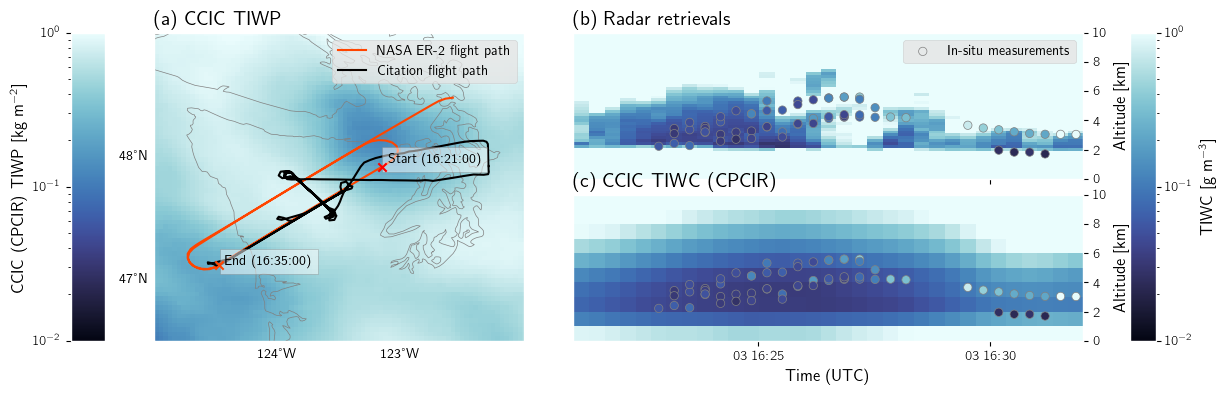

In [14]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 4))
gs = GridSpec(4, 4, width_ratios=[0.1, 1.1, 1.5, 0.075], wspace=0.2, hspace=0.25)

start = np.datetime64("2015-12-03T16:21:00", "s")
end = np.datetime64("2015-12-03T16:32:00", "s")

ind_start = np.where(radar_data.time > start)[0][0]
ind_end = np.where(radar_data.time > end)[0][0]
crs = area.to_cartopy_crs()

# CPCIR TIWP

ax = fig.add_subplot(gs[:4, 1], projection=crs)
m = ax.imshow(tiwp, extent=ext, norm=LogNorm(1e-2, 1e0), rasterized=True, cmap="cmo.ice")

ax.plot(radar_data.longitude.data, radar_data.latitude.data, c="orangered", label="NASA ER-2 flight path")
ax.plot(citation_data.longitude.data, citation_data.latitude.data, c="black", label="Citation flight path")
ax.legend()
ax.set_xlim(-125, -122)
ax.set_ylim(46.5, 49)

props = dict(facecolor='white', alpha=0.5, edgecolor="grey")
ax.text(radar_data.longitude.data[ind_start] + 0.05, radar_data.latitude.data[ind_start], "Start (16:21:00)", color="black", ha="left", va="bottom", bbox=props)
ax.scatter([radar_data.longitude.data[ind_start]], [radar_data.latitude.data[ind_start]], marker="x", color="red", zorder=10)
ax.text(radar_data.longitude.data[ind_end] + 0.05, radar_data.latitude.data[ind_end], "End (16:35:00)", color="black", bbox=props)
ax.scatter([radar_data.longitude.data[ind_end]], [radar_data.latitude.data[ind_end]], marker="x", color="orangered", zorder=10)
ax.set_title("(a) CCIC TIWP", loc="left")

add_ticks(ax, np.arange(-125, -121), np.arange(46.0, 50), bottom=True)
ax.coastlines(color="grey")

ax = fig.add_subplot(gs[:4, 0])
plt.colorbar(m, label="CCIC (CPCIR) TIWP [kg m$^{-2}$]", cax=ax, location="left")

# Radar results

ax = fig.add_subplot(gs[:2, 2])
norm = LogNorm(1e-2, 1e0)
x = time_rad
y = radar_data.altitude.data / 1e3
ax.pcolormesh(x, y, radar_data.iwc.T * 1e3, norm=norm, rasterized=True)
ax.scatter(time_r, citation_data.altitude / 1e3, c=citation_data.Nev_TWC, norm=norm, edgecolor="grey", label="In-situ measurements")
ax.legend()
ax.set_xticklabels([])
ax.set_ylabel("Altitude [km]")
ax.set_xlim(start, end)
ax.set_ylim(0, 10)
ax.set_title("(b) Radar retrievals", loc="left")
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

# CPCIR results

ax = fig.add_subplot(gs[2:4, 2])
x = ccic_cpcir_data.time.data
y = ccic_cpcir_data.altitude.data / 1e3
ax.pcolormesh(x, y, ccic_cpcir_data.tiwc.T, norm=norm, rasterized=True)
ax.scatter(time_r, citation_data.altitude / 1e3, c=citation_data.Nev_TWC, norm=norm, edgecolor="grey")

ax.set_xlim(start, end)
ax.set_ylabel("Altitude [km]")
ax.set_ylim(0, 10)
ax.set_title("(c) CCIC TIWC (CPCIR)", loc="left")
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
ax.set_xlabel("Time (UTC)")

ax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, label="TIWC [g m$^{-3}$]", cax=ax)
fig.savefig("../figures/olympex_case_study_cpcir.pdf", bbox_inches="tight")

## Plot particular flights

In [163]:
data_path = DATA_PATH / "validation/olympex/results_new"
radar_files = sorted(list(Path(data_path).glob("*.nc")))

In [178]:
for path in radar_files:
    with xr.open_dataset(path, group="LargePlateAggregate") as data:
        print(path, "latitude" in data)

/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511101728_201511101759.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511101758_201511101839.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511181824_201511181858.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511181858_201511181959.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511181959_201511182059.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511182058_201511182124.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511182219_201511182259.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511231537_201511231559.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_olympex_201511231558_201511231659.nc False
/home/simonpf/data_3/ccic/validation/olympex/results_new/crs_oly

In [228]:
cpcir_files = sorted(list(Path(DATA_PATH / "results/olympex/").glob("*cpcir*.nc")))
cpcir_times = np.array([
    to_datetime64(datetime.strptime(filename.name, "ccic_cpcir_%Y%m%d%H%M%S.nc")) 
    for filename in cpcir_files]
)
def load_cpcir_results(radar_data):
    
    start_time = radar_data.time.data[0]
    end_time = radar_data.time.data[-1]
    
    start_index = np.where(cpcir_times < start_time)[0]
    if len(start_index) == 0:
        start_index = 0
    else:
        start_index = start_index[-1]
        
    end_index = np.where(cpcir_times > end_time)[0]
    if len(end_index) == 0:
        end_index = 0
    else:
        end_index = end_index[0]
        
    cpcir_data = xr.open_mfdataset(cpcir_files[start_index:end_index+1]).compute()
    
    lons = radar_data.longitude
    lats = radar_data.latitude
    time = radar_data.time
    cpcir_data = cpcir_data.interp(time=time, latitude=lats, longitude=lons)
    
    return cpcir_data
    
    


In [229]:
radar_data = xr.load_dataset(radar_files[24], group="LargePlateAggregate")

In [230]:
cpcir_data = load_cpcir_results(radar_data)

In [232]:
from matplotlib.colors import LogNorm

def plot_overview(radar_data, cpcir_data):
    
    f, axs = plt.subplots(3, 1, figsize=(12, 8))
    norm = LogNorm(1e-2, 1e1)

    ax = axs[0]
    x = cpcir_data.time.data
    tiwp_cpcir = cpcir_data.tiwp.data
    alt = radar_data.altitude.data
    tiwp = np.trapz(radar_data.iwc.data, x=alt)
    ax.plot(x, tiwp)
    ax.plot(x, tiwp_cpcir)
    ax.set_xlim(x[0], x[-1])
    ax.set_xticklabels([])
    ax.set_ylabel("TIWP [kg m$^{-2}$]")

    ax = axs[1]
    x = cpcir_data.time.data
    y = cpcir_data.altitude.data / 1e3
    ax.pcolormesh(x, y, cpcir_data.tiwc.T, norm=norm, rasterized=True)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel("Altitude [km]")
    ax.set_xticklabels([])

    ax = axs[2]
    x = radar_data.time.data
    y = radar_data.altitude.data / 1e3
    ax.pcolormesh(x, y, radar_data.iwc.T * 1e3, norm=norm, rasterized=True)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel("Altitude [km]")
    ax.set_xlabel("Time")

## Evaluate radar-only retrieval

In [51]:
from scipy.stats import binned_statistic
t_bins = np.linspace(250, 280, 11)
err_bins = np.linspace(-40, 40, 41)

def calculate_log_error_dist(temperature, tiwc_ref, tiwc):
    """
    Calculate distribution of logarithmic retrieval errors w.r.t. temperature.
    
    Args:
        temperature: Array containing the atmospheric temperature.
        tiwc_ref: Array containing the reference TIWC measurements.
        tiwc: Array containing the retrieved TIWC.
        
    Return:
        A tuple ``(mean_err, dist)`` containing ``mean_err``, the logarithmic mean
        error for for each temperature bin and ``dist``, the joint distribution of
        of logarithmic retrieval error by temperature.
    """
    valid = (tiwc_ref >= 0) * (tiwc >= 0) * (temperature < 273.15)
    temperature = temperature[valid]
    tiwc_ref = tiwc_ref[valid]
    tiwc = tiwc[valid]
    
    print(temperature.min(), temperature.max())
    
    tiwc_mean = binned_statistic(temperature, tiwc, bins=t_bins)[0]
    tiwc_ref_mean = binned_statistic(temperature, tiwc_ref, bins=t_bins)[0]
    
    mean_err = 10 * np.log10(tiwc_mean / tiwc_ref_mean)
    
    err = 10 * np.log10(tiwc / tiwc_ref)
    dist = np.histogram2d(temperature, err, bins=(t_bins, err_bins), density=True)[0].T
    dist /= dist.sum(0, keepdims=True)
    return mean_err, dist
    
    

In [52]:
tiwc_ref_8ca = results_cpcir["8-ColumnAggregate"].tiwc_citation.data
tiwc_8ca = results_cpcir["8-ColumnAggregate"].tiwc_radar.data * 1e3
temp = results_cpcir["8-ColumnAggregate"].temperature.data
valid = (tiwc_ref_8ca >= 0) * (tiwc_8ca >= 0) * (temp < 273.15)
temp = temp[valid]
tiwc_ref_8ca = tiwc_ref_8ca[valid]
tiwc_8ca = tiwc_8ca[valid]
mean_err_8ca, err_8ca = calculate_log_error_dist(temp, tiwc_ref_8ca, tiwc_8ca)

tiwc_ref_lpa = results_cpcir["LargePlateAggregate"].tiwc_citation.data
tiwc_lpa = results_cpcir["LargePlateAggregate"].tiwc_radar.data * 1e3
temp = results_cpcir["LargePlateAggregate"].temperature.data
valid = (tiwc_ref_lpa >= 0) * (tiwc_lpa >= 0) * (temp < 273.15)
temp = temp[valid]
tiwc_ref_lpa = tiwc_ref_lpa[valid]
tiwc_lpa = tiwc_lpa[valid]
mean_err_lpa, err_lpa = calculate_log_error_dist(temp, tiwc_ref_lpa, tiwc_lpa)

tiwc_ref_lca = results_cpcir["LargeColumnAggregate"].tiwc_citation.data
tiwc_lca = results_cpcir["LargeColumnAggregate"].tiwc_radar.data * 1e3
temp = results_cpcir["LargeColumnAggregate"].temperature.data
valid = (tiwc_ref_lca >= 0) * (tiwc_lca >= 0) * (temp < 273.15)
temp = temp[valid]
tiwc_ref_lca = tiwc_ref_lca[valid]
tiwc_lca = tiwc_lca[valid]
mean_err_lca, err_lca = calculate_log_error_dist(temp, tiwc_ref_lca, tiwc_lca)

234.72658 271.62836


/tmp/ipykernel_1190961/2094186055.py:33: RuntimeWarning: invalid value encountered in divide
  dist /= dist.sum(0, keepdims=True)


234.72658 271.62836
234.72658 271.62836


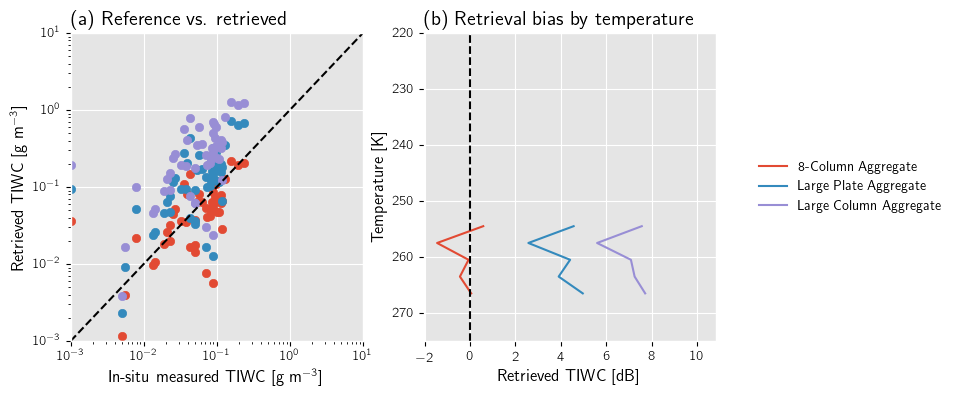

In [53]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(11, 4))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.5], wspace=0.25)

ax = fig.add_subplot(gs[0, 0])
x = np.logspace(-3, 1, 101)
ax.plot(x, x, ls="--", c="k")
ax.scatter(tiwc_ref_8ca, tiwc_8ca)
ax.scatter(tiwc_ref_lpa, tiwc_lpa)
ax.scatter(tiwc_ref_lca, tiwc_lca)
ax.set_xlabel("In-situ measured TIWC [g m$^{-3}$]")
ax.set_ylabel("Retrieved TIWC [g m$^{-3}$]")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e1)
ax.set_xlim(1e-3, 1e1)
ax.set_title("(a) Reference vs. retrieved", loc="left")

ax = fig.add_subplot(gs[0, 1])
temps = 0.5 * (t_bins[1:] + t_bins[:-1])

handles = []
handles += ax.plot(mean_err_8ca, temps, label="8-Column Aggregate")
handles += ax.plot(mean_err_lpa, temps, label="Large Plate Aggregate")
handles += ax.plot(mean_err_lca, temps, label="Large Column Aggregate")

ax.set_xlabel("Retrieved TIWC [dB]")
ax.set_ylabel("Temperature [K]")
ax.set_ylim(275, 220)
ax.axvline(0, ls="--", c="k")
ax.set_title("(b) Retrieval bias by temperature", loc="left")

ax = fig.add_subplot(gs[0, -1])
ax.set_axis_off()
ax.legend(handles=handles, edgecolor="none", facecolor="none", loc="center")
fig.savefig("../figures/olympex_radar_retrieval.pdf", bbox_inches="tight")

In [41]:
valid = (tiwc_ref_8ca >= 0) * (tiwc_8ca >= 0)
rel_bias = 100 * ((tiwc_8ca[valid].mean() / tiwc_ref_8ca[valid].mean()) - 1.0)
corr = np.corrcoef(tiwc_8ca[valid], tiwc_ref_8ca[valid])[0, 1]
rel_bias, corr

(-13.059362489243288, 0.7376858954386911)

In [42]:
valid = (tiwc_ref_lpa >= 0) * (tiwc_lpa >= 0)
rel_bias = 100 * ((tiwc_lpa[valid].mean() / tiwc_ref_lpa[valid].mean()) - 1.0)
corr = np.corrcoef(tiwc_lpa[valid], tiwc_ref_lpa[valid])[0, 1]
rel_bias, corr

(140.63556013181633, 0.7361525847153985)

In [43]:
valid = (tiwc_ref_lca >= 0) * (tiwc_lca >= 0)
rel_bias = 100 * ((tiwc_lca[valid].mean() / tiwc_ref_lca[valid].mean()) - 1.0)
corr = np.corrcoef(tiwc_lca[valid], tiwc_ref_lca[valid])[0, 1]
rel_bias, corr

(379.5270750191867, 0.7346247198892658)